In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

In [2]:
df = pd.read_csv("6assign3.csv")

In [10]:
df.head(12)

,time,value
0,1,0.52
1,2,0.52
2,3,0.43
3,4,0.10
4,5,0.44
5,6,1.64
6,7,2.04
7,8,0.65
8,9,-2.47
9,10,-4.67


Some score values are negative, which might appear counterintuitive.
However, knowing that these vaues are the changes in IMDb scores across episodes, with negative values indicating decreases and positive values indicating increases, these values can be accepted.

In [8]:
# Fit a linear deterministic model: IMDb score as a function of time
X = sm.add_constant(df['time'])  # Add intercept
y = df['value']
model = sm.OLS(y, X).fit()

# Display model coefficients
print("Model Coefficients:")
print(model.params)

Model Coefficients:
const   -10.624286
time     -0.196867
dtype: float64


### Residuals

In [12]:
residuals = model.resid

# 1. Mean of residuals
mean_residuals = np.mean(residuals)
print(f"\nMean of residuals: {mean_residuals:.4f}")

# 2. Normality test (Shapiro-Wilk)
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")

# 3. Independence of residuals (Durbin-Watson)
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat:.4f}")

# 4. Homoscedasticity (Breusch-Pagan)
bp_test = het_breuschpagan(residuals, X)
print(f"Breusch-Pagan Test: LM Statistic={bp_test[0]:.4f}, p-value={bp_test[1]:.4f}")


Mean of residuals: -0.0000
Shapiro-Wilk Test: Statistic=0.8970, p-value=0.0004
Durbin-Watson Statistic: 0.0229
Breusch-Pagan Test: LM Statistic=2.1051, p-value=0.1468


### Interpretation:

- Mean of Residuals (0): The mean of the residuals is effectively zero, satisfying the assumption that the expected value of residuals is zero.

- Shapiro-Wilk Test (Statistic=0.8970, p-value=0.0004): The p-value is less than 0.05, indicating the residuals are not normally distributed. This violates the normality assumption.

- Durbin-Watson Statistic (0.0229): The value is very close to 0, suggesting strong positive autocorrelation in the residuals. This violates the independence assumption.

- Breusch-Pagan Test (LM Statistic=2.1051, p-value=0.1468): The p-value is greater than 0.05, indicating no evidence of heteroscedasticity. The residuals exhibit constant variance, satisfying the homoscedasticity assumption.

Predictions for episodes 51 to 60:
0   -20.664514
1   -20.861382
2   -21.058249
3   -21.255116
4   -21.451983
5   -21.648850
6   -21.845718
7   -22.042585
8   -22.239452
9   -22.436319
dtype: float64


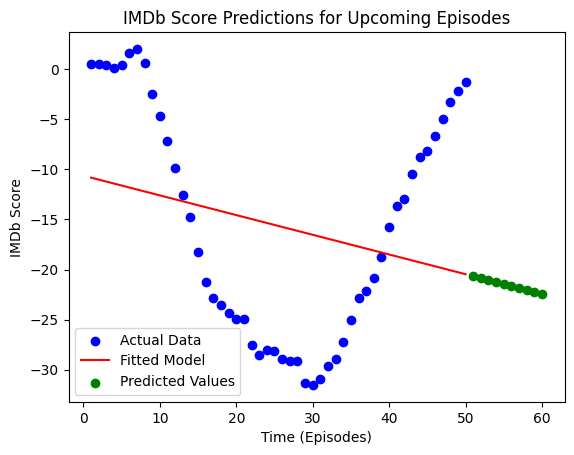

In [17]:
# Predictions for future episodes
future_time = pd.DataFrame({'time': range(51, 61)})  # Time for episodes 51 to 60
future_time = sm.add_constant(future_time)  # Add intercept
predictions = model.predict(future_time)

# Display predictions
print("Predictions for episodes 51 to 60:")
print(predictions)

# Plot the data and predictions
plt.scatter(df['time'], y, label='Actual Data', color='blue')
plt.plot(df['time'], model.predict(X), label='Fitted Model', color='red')
plt.scatter(future_time['time'], predictions, label='Predicted Values', color='green')
plt.xlabel('Time (Episodes)')
plt.ylabel('IMDb Score')
plt.title('IMDb Score Predictions for Upcoming Episodes')
plt.legend()
plt.show()

### Overall model assessment: 

Clearly the model is not doing a good job neither in fitting the data nor predicting future values: the fitted model is so far away from the actual data points and the predicted values are on a totally different scale

In [18]:
# Model significance (F-statistic and p-value)
f_stat = model.fvalue
f_pval = model.f_pvalue
print(f"Model F-statistic: {f_stat:.4f}, p-value: {f_pval:.4e}")

# Significance of explanatory variable (time)
coeff_summary = model.summary2().tables[1]  # Extract coefficient summary
print("\nSignificance of explanatory variable:")
print(coeff_summary)

# Extract p-value for the explanatory variable
time_pval = coeff_summary.loc['time', 'P>|t|']
print(f"\nP-value for 'time': {time_pval:.4e}")


Model F-statistic: 3.1915, p-value: 8.0341e-02

Significance of explanatory variable:
           Coef.  Std.Err.         t     P>|t|     [0.025    0.975]
const -10.624286  3.228857 -3.290417  0.001880 -17.116337 -4.132234
time   -0.196867  0.110199 -1.786466  0.080341  -0.418438  0.024703

P-value for 'time': 8.0341e-02


**Even the the overall model seems to be significant (p-value < 0.05) , which is probably thanks to the intercept, the one expanatory variable used "time" is not significant (p-value > 0.05)**

## Exponential Smoothing

Simple exponential smoothing is used, no seasonal or trend components.

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Apply Exponential Smoothing
model_es = ExponentialSmoothing(df['value'], trend=None, seasonal=None, seasonal_periods=None).fit()

# Get fitted values and predictions
df['fitted'] = model_es.fittedvalues
future_time = pd.DataFrame({'time': range(51, 61)})
predictions = model_es.forecast(steps=10)  # Forecast for 10 future episodes

# Display model results
print("Exponential Smoothing Model Summary:")
print(model_es.summary())

Exponential Smoothing Model Summary:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    value   No. Observations:                   50
Model:             ExponentialSmoothing   SSE                            137.549
Optimized:                         True   AIC                             54.598
Trend:                             None   BIC                             58.422
Seasonal:                          None   AICC                            55.487
Seasonal Periods:                  None   Date:                 Fri, 06 Dec 2024
Box-Cox:                          False   Time:                         22:39:24
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 Tr

## Exponential Smoothig model assessment

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(df['value'], df['fitted'])
mse = mean_squared_error(df['value'], df['fitted'])
mape = mean_absolute_percentage_error(df['value'], df['fitted']) * 100 
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 1.3446
Mean Squared Error (MSE): 2.7510
Mean Absolute Percentage Error (MAPE): 29.19%


**The MAPE value is the easiest to interpret, and it shows here that on average, the model’s predictions are off by 29% compared to the actual scores.**


Predictions for upcoming episodes (51-60):
50   -1.25
51   -1.25
52   -1.25
53   -1.25
54   -1.25
55   -1.25
56   -1.25
57   -1.25
58   -1.25
59   -1.25
dtype: float64


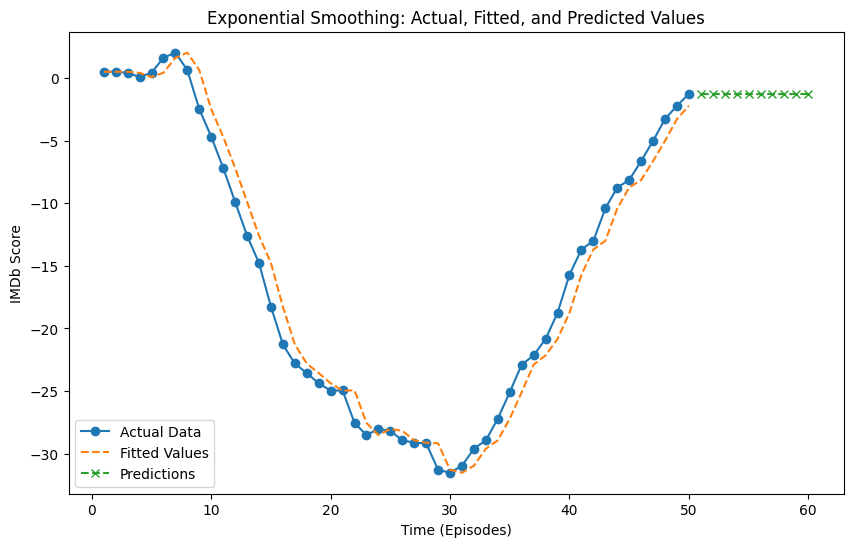

In [21]:
# Predictions
print("\nPredictions for upcoming episodes (51-60):")
print(predictions)

# Plot actual values, fitted values, and predictions
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['value'], label='Actual Data', marker='o')
plt.plot(df['time'], df['fitted'], label='Fitted Values', linestyle='--')
plt.plot(range(51, 61), predictions, label='Predictions', marker='x', linestyle='--')
plt.xlabel('Time (Episodes)')
plt.ylabel('IMDb Score')
plt.title('Exponential Smoothing: Actual, Fitted, and Predicted Values')
plt.legend()
plt.show()

**Interpretation:**
- The fitted values from the exponential smoothing model closely follow the actual data. This indicates that the model captures the general pattern of the data.
- The predictions for episodes 51–60 are shown as flat and constant. This suggests the model assumes no significant change beyond episode 50. Despite that these predictions are much more accurate than those performed by the deterministic model.

## Box-Jenkins: using ARIMA(1,1,0)

First we tried with ARIMA (1,1,1), we found that the MA component is not significant, and removing it slightly lowered AIC and BIC and slightly improved the MAPE, so we opted for ARIMA (1,1,0) instead.

In [49]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (p, d, q) - example: ARIMA(1,1,1)
model = ARIMA(df['value'], order=(1, 1, 0))
fitted_model = model.fit()

# Display model summary
print("ARIMA Model Summary:")
print(fitted_model.summary())

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -69.066
Date:                Fri, 06 Dec 2024   AIC                            142.133
Time:                        23:06:14   BIC                            145.917
Sample:                             0   HQIC                           143.568
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7983      0.101      7.937      0.000       0.601       0.995
sigma2         0.9612      0.194      4.946      0.000       0.580       1.342
Ljung-Box (L1) (Q):            

In [50]:
# Make predictions for upcoming episodes
forecast = fitted_model.forecast(steps=10)  # Forecast for 10 future episodes
print("\nPredictions for episodes 51-60:")
print(forecast)

# Assess model fit using residuals
residuals = fitted_model.resid
mape = mean_absolute_percentage_error(df['value'][:], fitted_model.fittedvalues)
print(f"\nMean Absolute Percentage Error (MAPE): {mape:.2f}%")


Predictions for episodes 51-60:
50   -0.491662
51    0.113681
52    0.596897
53    0.982624
54    1.290531
55    1.536318
56    1.732517
57    1.889133
58    2.014152
59    2.113949
Name: predicted_mean, dtype: float64

Mean Absolute Percentage Error (MAPE): 0.23%


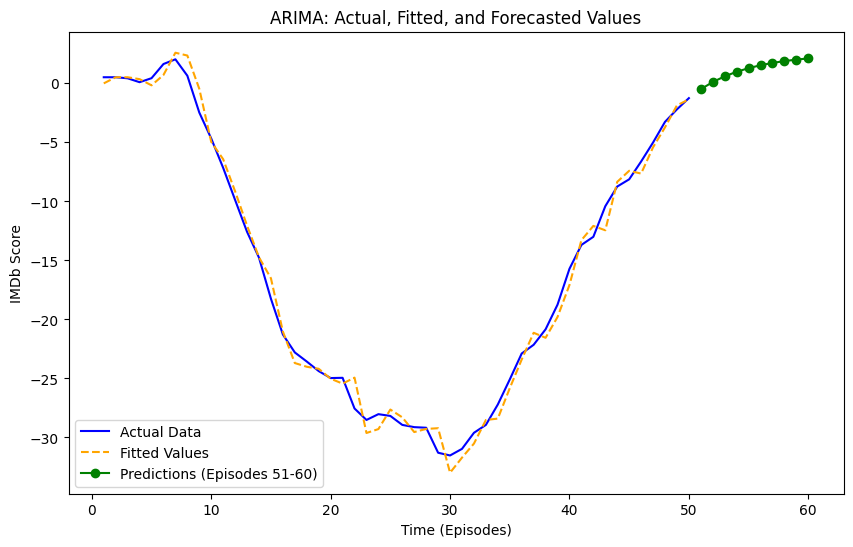

In [51]:
# Plot actual vs fitted and forecast
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['value'], label='Actual Data', color='blue')
plt.plot(df['time'][:], fitted_model.fittedvalues, label='Fitted Values', linestyle='--', color='orange')
plt.plot(range(51, 61), forecast, label='Predictions (Episodes 51-60)', marker='o', color='green')
plt.xlabel('Time (Episodes)')
plt.ylabel('IMDb Score')
plt.title('ARIMA: Actual, Fitted, and Forecasted Values')
plt.legend()
plt.show()

### Interpretation:

- The actual and fitted alues are closely aligned, indicating that the ARIMA(1,1,0) model captures the historical data well.
- Forecasted Values: The forecasted values show a continuation of the upward trend observed toward the end of the actual data. The model projects a steady increase, consistent with the recent pattern in the data.
- This ARIMA model clearly overperforms the previous 2 models (deterministic and exponential smoothing), not only in terms of visual fit but also MAPE: very low MAPE for the ARIMA model = 0.23%